# Solving the mild-slope equation in a two spherical shoal using PINN
## Bibliography
### Numerical solutions of mild slope equation by generalized ﬁnite diﬀerence method. Authors: Ting Zhang, Ying-Jie Huang, Lin Liang, Chia-Ming Fan, Po-Wei Li
### A Modified Mild‐Slope Model for the Hydrodynamic Analysis of Arrays of Heaving WECs in Variable Bathymetry Regions. Authors: Markos Bonovas, Alexandros Magkouris and Kostas Belibassakis 

# Libraries

In [1]:
import jax, optax
import pickle
import functools
import matplotlib.pyplot, matplotlib.animation
import numpy
import pandas

import utils
# Set and verify device
jax.config.update('jax_platform_name', 'gpu')
jax.config.update("jax_enable_x64", True)
print(jax.lib.xla_bridge.get_backend().platform)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
gpu


# Parameters

In [2]:
# Neural network parameters
parameters = {}
parameters['seed'] = 351
parameters['n_features'] = 2        # Input dimension (x1, x2)
parameters['n_targets'] = 2         # Output dimension. It's a complex number (y1 + j*y2)
parameters['hidden_layers'] = [50, 50, 50, 50, 50]   # Hidden layers structure
parameters['layers'] = [parameters['n_features']] + parameters['hidden_layers'] + [parameters['n_targets']]

# Training parameters
parameters['eta'] = 100.0 
parameters['learning_rate'] = 0.005
parameters['optimizer'] = optax.adam(parameters['learning_rate'])
parameters['maximum_num_epochs'] = 2500
parameters['report_steps'] = 100
parameters['options'] = 2          # 1: we start a new training. 2: We continue the last training. 
                                    # Other cases: We just load the last training

# Neural network

In [3]:
class MLP:
    """
        Create a multilayer perceptron and initialize the neural network
    Inputs :
        A SEED number and the layers structure
    """
    def __init__(self, key, layers):
        self.key = key
        self.keys = jax.random.split(self.key,len(layers))
        self.layers = layers
        self.params = []

    def MLP_create(self):
        """
        Initialize the MLP weigths and bias
        Parameters
        ----------
        Returns
        -------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        """
        for layer in range(0, len(self.layers)-1):
            in_size,out_size = self.layers[layer], self.layers[layer+1]
            weights = jax.nn.initializers.glorot_normal()(self.keys[layer], (out_size, in_size), jax.numpy.float32)
            bias = jax.nn.initializers.lecun_normal()(self.keys[layer], (out_size, 1), jax.numpy.float32).reshape((out_size, ))
            self.params.append((weights, bias))
        return self.params
        

    @functools.partial(jax.jit, static_argnums=(0,))    
    def NN_evaluation(self, params, inputs):
        """
        Evaluate a position XY using the neural network    
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inputs : jax.numpy.ndarray[[batch_size,batch_size]]
            -- points in the mesh
        Returns
        -------
        output : jax.numpy.array[batch_size]
            -- neural network output 
        """
        for layer in range(0, len(params)-1):
            weights, bias = params[layer]
            inputs = jax.nn.tanh(jax.numpy.add(jax.numpy.dot(inputs, weights.T), bias))
        weights, bias = params[-1]
        real_and_imaginary_layers = jax.numpy.dot(inputs, weights.T)+bias # The first output of the NN is the real part, the second is the imaginary part
        output = jax.lax.complex(real_and_imaginary_layers[0], real_and_imaginary_layers[1])   

        return output


# Operators

In [4]:
class PDE_operators:
    """
        Class with the operators used to solve the PDE
    Input:
        A function that we want to compute the respective operator
    """
    def __init__(self, psi_function, c_function, cg_function):
        self.psi_function = psi_function
        self.c_function = c_function
        self.cg_function = cg_function


    @functools.partial(jax.jit, static_argnums=(0,))    
    def grad_psi(self, params, inputs):
        """
        Compute the gradient of the psi function
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inputs : jax.numpy.ndarray[[batch_size,batch_size]]
            -- coordinates and time  (x,y)
        Returns
        -------
        gradient : jax.numpy.ndarray[[batch_size,batch_size]]
            -- numerical values of the gradient applied to the inputs
        """

        fun = lambda params, x, y: self.psi_function(params, x, y)

        @functools.partial(jax.jit)    
        def action(params, x, y):               # function to vectorize the laplacian
            u_x = jax.jacfwd(fun, 1)(params, x, y)
            u_y = jax.jacfwd(fun, 2)(params, x, y)
            return jax.numpy.column_stack((u_x, u_y))

        vec_fun = jax.vmap(action, in_axes = (None, 0, 0))
        gradient = vec_fun(params, inputs[:,0], inputs[:,1])
        gradient = gradient.reshape((gradient.shape[0], gradient.shape[2]))

        return gradient


    @functools.partial(jax.jit, static_argnums=(0,))    
    def grad_c_cg_grad_psi(self, params, inputs):
        """
        Compute the dot product nabla.(c*cg*gradpsi)
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inputs : jax.numpy.ndarray[[batch_size,batch_size,batch_size]]
            -- coordinates and time  (x,y)
        Returns
        -------
        res : jax.numpy.ndarray[[batch_size,batch_size]]
            -- numerical values of the dot_product nabla.(c*cg*gradpsi) applied to the inputs
        """

        funx = lambda params, x, y: self.c_function(x,y)*self.cg_function(x,y)*self.grad_psi(params, jax.numpy.column_stack((x, y)))[:,0]
        funy = lambda params, x, y: self.c_function(x,y)*self.cg_function(x,y)*self.grad_psi(params, jax.numpy.column_stack((x, y)))[:,1]

        @functools.partial(jax.jit)    
        def action(params, x, y):               # function to vectorize the laplacian
            u_x = jax.jacfwd(funx, 1)(params, x, y)
            u_y = jax.jacfwd(funy, 2)(params, x, y)
            return u_x + u_y

        vec_fun = jax.vmap(action, in_axes = (None, 0, 0))
        res = vec_fun(params, inputs[:,0], inputs[:,1])

        return res.reshape(-1)


    @functools.partial(jax.jit, static_argnums=(0,))    
    def dsol_dt(self, params, inputs):
        """
        Compute the time derivative os the solution
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inputs : jax.numpy.ndarray[[batch_size,batch_size,batch_size,batch_size]]
            -- coordinates and time  (x,y,z,t)
        Returns
        -------
        res : jax.numpy.ndarray[batch_size]
            -- numerical values of the time derivative applied to the inputs
        """

        fun = lambda params, x, y, z, t: self.psi_function(params, x, y, z, t)

        @functools.partial(jax.jit)    
        def action(params, x, y, z, t):               # function to vectorize the laplacian
            u_t = jax.jacfwd(fun, 4)(params, x, y, z, t)
            return u_t

        vec_fun = jax.vmap(action, in_axes = (None, 0, 0, 0, 0))
        res = vec_fun(params, inputs[:,0], inputs[:,1], inputs[:,2], inputs[:,3])
        normal_left = jax.numpy.column_stack((-jax.numpy.ones(inputs.shape[0]), jax.numpy.zeros(inputs.shape[0])))
        normal_behind = jax.numpy.column_stack((jax.numpy.zeros(inputs.shape[0]),jax.numpy.ones(inputs.shape[0])))
        normal_right = jax.numpy.column_stack((jax.numpy.ones(inputs.shape[0]), jax.numpy.zeros(inputs.shape[0])))
        normal_front = jax.numpy.column_stack((jax.numpy.zeros(inputs.shape[0]),jax.numpy.ones(inputs.shape[0])))

        return res.reshape(-1)


# Physics domain

In [5]:
class PHYSICS_FUNCTIONS():
    """
        Class with the physical approach and parameters
    Input:
        Wave vector, spatial 2d solution of the mild-slope equation and shoal coordinates
    """
    
    # Class initialization
    def __init__(self, wave_vector, spatial_2dsolution, shoal_coordinates):
        self.spatial_2dsolution = spatial_2dsolution
        self.wave_vector = wave_vector
        self.shoal_coordinates = shoal_coordinates

        self.operators = PDE_operators(self.solution, self.c_coeff, self.cg_coeff)
        self.dsol_dt = self.operators.dsol_dt

    @functools.partial(jax.jit, static_argnums=(0,))    
    def omega_coeff(self, x, y):
        """
        Compute the frequency omega at in the couple (x,y)
        Parameters
        ----------
        x : jax.numpy.ndarray[batch_size]
            -- points in the axis x
        y : jax.numpy.ndarray[batch_size]
            -- points in the axis y
        Returns
        -------
        omega : jax.numpy.ndarray[batch_size]
            -- omega in each couple (x,y)
        """
        omega = jax.numpy.sqrt(9.81*self.k_coeff(x,y)*jax.numpy.tanh(self.k_coeff(x,y)*self.height_function(x,y)))
        
        return omega


    @functools.partial(jax.jit, static_argnums=(0,))    
    def k_coeff(self, x, y):
        """
        Compute the coefficient k in the couple (x,y)
        Parameters
        ----------
        x : jax.numpy.ndarray[batch_size]
            -- points in the axis x
        y : jax.numpy.ndarray[batch_size]
            -- points in the axis y
        Returns
        -------
        k : jax.numpy.ndarray[batch_size]
            -- Coefficient k in each couple (x,y)
        """

        return self.wave_vector


    @functools.partial(jax.jit, static_argnums=(0,))    
    def c_coeff(self, x, y):
        """
        Compute the coefficient c in the couple (x,y)
        Parameters
        ----------
        x : jax.numpy.ndarray[batch_size]
            -- points in the axis x
        y : jax.numpy.ndarray[batch_size]
            -- points in the axis y
        Returns
        -------
        c : jax.numpy.ndarray[batch_size]
            -- Coefficient c in each couple (x,y)
        """
        c = self.omega_coeff(x,y)/self.k_coeff(x,y)

        return c


    @functools.partial(jax.jit, static_argnums=(0,))    
    def cg_coeff(self, x, y):
        """
        Compute the coefficient cg in the couple (x,y)
        Parameters
        ----------
        x : jax.numpy.ndarray[batch_size]
            -- points in the axis x
        y : jax.numpy.ndarray[batch_size]
            -- points in the axis y
        Returns
        -------
        cg : jax.numpy.ndarray[batch_size]
            -- Coefficient cg in each couple (x,y)
        """
        nprime = 0.5*(1 + 2*self.k_coeff(x,y)*self.height_function(x,y)/jax.numpy.sinh(2*self.k_coeff(x,y)*self.height_function(x,y)))
        cg = nprime*self.omega_coeff(x,y)/self.k_coeff(x,y)

        return cg


    @functools.partial(jax.jit, static_argnums=(0,))    
    def height_function(self, x, y):
        """
        Compute the height in the couple (x,y)
        Parameters
        ----------
        x : jax.numpy.ndarray[batch_size]
            -- points in the axis x
        y : jax.numpy.ndarray[batch_size]
            -- points in the axis y
        Returns
        -------
        h : jax.numpy.ndarray[batch_size]
            -- Height each couple (x,y)
        """
        fun = lambda tx, ty: self.shoal_coordinates[:,2][jax.numpy.argmin(jax.numpy.sqrt(((tx-self.shoal_coordinates[:,0])**2+(ty-self.shoal_coordinates[:,1])**2)))]
        vec_fun = jax.vmap(jax.jit(fun), in_axes = (0, 0))
        h = -vec_fun(x.reshape(-1), y.reshape(-1))

        return h


    @functools.partial(jax.jit, static_argnums=(0,))    
    def f_dependence(self, inputX, inputY, inputZ):
        """
        Compute the function fz in the point (x,y,z)
        Parameters
        ----------
        x : jax.numpy.ndarray[batch_size]
            -- points in the axis x
        y : jax.numpy.ndarray[batch_size]
            -- points in the axis y
        z : jax.numpy.ndarray[batch_size]
            -- points in the axis z
        Returns
        -------
        fz : jax.numpy.ndarray[batch_size]
            -- fz in each point (x,y,z)
        """
        fz = (jax.numpy.cosh(self.k_coeff(inputX, inputY)*(self.height_function(inputX, inputY)+ inputZ))/jax.numpy.cosh(self.k_coeff(inputX, inputY)*self.height_function(inputX, inputY))).reshape(-1)

        return fz


    @functools.partial(jax.jit, static_argnums=(0,))    
    def incident_psi(self, params, inputs, a=0.01):
        """
        Compute the incident wave in inputs points
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inputs : jax.numpy.ndarray[[batch_size, batch_size]]
            -- (x,y) points in the mesh
        Returns
        -------
        incident_wave : a float.64
            -- incident_wave applied to inputs
        """
        incident_wave = (2*a*9.81/self.c_coeff(inputs[:,0], inputs[:,1])*jax.numpy.exp(-self.k_coeff(inputs[:,0],inputs[:,1])*(inputs[:,0]-0.5)*2*jax.numpy.pi)).reshape(-1)
        
        return incident_wave


    @functools.partial(jax.jit, static_argnums=(0,))    
    def solution(self, params, x,y,z,t):
        """
        Compute the solution in the point (x,y,z,t)
        Parameters
        ----------
        x : jax.numpy.ndarray[batch_size]
            -- points in the axis x
        y : jax.numpy.ndarray[batch_size]
            -- points in the axis y
        z : jax.numpy.ndarray[batch_size]
            -- points in the axis z
        t : jax.numpy.ndarray[batch_size]
            -- points in the time
        Returns
        -------
        res : jax.numpy.ndarray[batch_size]
            -- result in each point (x,y,z,t)
        """
        H = 2*self.omega_coeff(x,y)*abs(self.spatial_2dsolution(params,x,y))/9.81
        res = jax.numpy.imag(9.81*H/(2*self.omega_coeff(x,y))*self.spatial_2dsolution(params, x,y)*self.f_dependence(x,y,z)*jax.numpy.exp(jax.lax.complex(0.0,jax.numpy.real(-self.omega_coeff(x,y)*t))))

        return res


    @functools.partial(jax.jit, static_argnums=(0,))    
    def elevation(self, params, x,y,t):
        """
        Compute the surface displacement in the point (x,y,t)
        Parameters
        ----------
        x : jax.numpy.ndarray[batch_size]
            -- points in the axis x
        y : jax.numpy.ndarray[batch_size]
            -- points in the axis y
        t : jax.numpy.ndarray[batch_size]
            -- points in the time
        Returns
        -------
        res : jax.numpy.ndarray[batch_size]
            -- Displacement in each point (x,y,z,t)
        """
        inputs = jax.numpy.column_stack((x,y,jax.numpy.zeros_like(y),t))
        res = -self.dsol_dt(params, inputs)/9.81

        return res

# Physics Informed Neural Network

In [6]:
class PINN:
    """
    Solve a PDE using Physics Informed Neural Networks   
    Input:
        The evaluation function of the neural network
    """
    def __init__(self, NN_evaluation, optimizer, XYZ_shoal):
        self.NN_evaluation = NN_evaluation
        self.optimizer = optimizer

        physics_parameters = PHYSICS_FUNCTIONS(wave_vector = 0.05, spatial_2dsolution = self.spatial_2dsolution, shoal_coordinates = XYZ_shoal)
        self.k_coeff = physics_parameters.k_coeff
        self.c_coeff = physics_parameters.c_coeff
        self.cg_coeff = physics_parameters.cg_coeff
        self.incident_psi = physics_parameters.incident_psi
        self.elevation = physics_parameters.elevation

        self.operators = PDE_operators(self.spatial_2dsolution, self.c_coeff, self.cg_coeff)
        self.gradient_psi = self.operators.grad_psi
        self.dsol_dt = self.operators.dsol_dt
        self.gradient_c_cg_gradpsi = self.operators.grad_c_cg_grad_psi


    @functools.partial(jax.jit, static_argnums=(0,))    
    def spatial_2dsolution(self, params, inputX, inputY):
        """
        Compute the solution of the PDE on the points (x,y)
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inputX : jax.numpy.array[batch_size]
            -- points on the x-axis of the mesh
        inputY : jax.numpy.array[batch_size]
            -- points on the y-axis of the mesh
        Returns
        -------
        applied_solution : jax.numpy.ndarray[batch_size]
            -- PINN solution applied to inputs. return u, a complex number
        """
        inputs = jax.numpy.column_stack((inputX, inputY))
        NN_output = jax.vmap(functools.partial(jax.jit(self.NN_evaluation), params))(inputs)
        
        return NN_output


    @functools.partial(jax.jit, static_argnums=(0,))    
    def loss_residual(self, params, inside_points):
        """
        Compute the residual of the pde inside the domain
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inside : jax.numpy.ndarray[[batch_size, batch_size]]
            -- (x,y) points from the mesh
        Returns
        -------
        loss_residual : a float.64
            -- loss function applied to inside_points
        """

        pred_loss_res = self.gradient_c_cg_gradpsi(params, inside_points) + self.k_coeff(inside_points[:,0],inside_points[:,1])**2*self.c_coeff(inside_points[:,0], inside_points[:,1])*self.cg_coeff(inside_points[:,0], inside_points[:,1])*self.spatial_2dsolution(params, inside_points[:,0], inside_points[:,1])
        loss_res = jax.numpy.linalg.norm(pred_loss_res)**2/pred_loss_res.shape[0]
        
        return loss_res


    @functools.partial(jax.jit, static_argnums=(0,))    
    def loss_boundary(self, params, boundary_points_list, boundary_normals_list):
        """
        Compute the loss function at the boundary
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        bound : jax.numpy.ndarray[[batch_size, batch_size]]
            -- (x,y) points from boundary
        Returns
        -------
        loss_front : a float.64
            -- loss function applied to boundary_points
        """
        boundary_points, unit_normal_vector = boundary_points_list[0], -boundary_normals_list[0]
        neumann_incident = jax.numpy.einsum('ij,ij->i', self.gradient_psi(params, boundary_points), unit_normal_vector) - jax.lax.complex(-jax.numpy.imag(self.k_coeff(boundary_points[:,0], boundary_points[:,1])*(2*self.incident_psi(params, boundary_points)-self.spatial_2dsolution(params, boundary_points[:,0], boundary_points[:,1]))), jax.numpy.real(self.k_coeff(boundary_points[:,0], boundary_points[:,1])*(2*self.incident_psi(params, boundary_points)-self.spatial_2dsolution(params, boundary_points[:,0], boundary_points[:,1])))) 
        neumann_incident = jax.numpy.linalg.norm(neumann_incident)**2/neumann_incident.shape[0]

        boundary_points, unit_normal_vector = boundary_points_list[1], boundary_normals_list[1]
        neumann_zero_up = jax.numpy.einsum('ij,ij->i',self.gradient_psi(params, boundary_points), unit_normal_vector)
        neumann_zero_up = jax.numpy.linalg.norm(neumann_zero_up)**2/neumann_zero_up.shape[0]

        boundary_points, unit_normal_vector = boundary_points_list[2], boundary_normals_list[2]
        neumann_absorbent = jax.numpy.einsum('ij,ij->i',self.gradient_psi(params, boundary_points), unit_normal_vector) - jax.lax.complex(-jax.numpy.imag(self.k_coeff(boundary_points[:,0], boundary_points[:,1])*self.spatial_2dsolution(params, boundary_points[:,0], boundary_points[:,1])), jax.numpy.real(self.k_coeff(boundary_points[:,0], boundary_points[:,1])*self.spatial_2dsolution(params, boundary_points[:,0], boundary_points[:,1])))
        neumann_absorbent = jax.numpy.linalg.norm(neumann_absorbent)**2/neumann_absorbent.shape[0]

        boundary_points, unit_normal_vector = boundary_points_list[3], boundary_normals_list[3]
        neumann_zero_down = jax.numpy.einsum('ij,ij->i',self.gradient_psi(params, boundary_points), unit_normal_vector)
        neumann_zero_down = jax.numpy.linalg.norm(neumann_zero_down)**2/neumann_zero_down.shape[0]

        means = jax.numpy.array([neumann_incident, neumann_zero_up, neumann_absorbent, neumann_zero_down])
        loss_bound = jax.numpy.mean(means)

        return loss_bound


    # Definition of the loss function mentioned above   
    @functools.partial(jax.jit, static_argnums = (0, ))    
    def loss_function(self, params, inside_points, boundary_points, boundary_normals):
        """
        Compute the sum of each loss function
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inside_points : jax.numpy.ndarray[[N,N]]
            -- (x,y) points from the domain
        boundary_points : jax.numpy.ndarray[[M,M]]
            -- (x,y) points from boundary
        Returns
        -------
        loss : a float.64
            -- loss function applied to inputs
        losses : numpy.array(loss_residual, loss_b, loss_i)
            -- current values of each loss function
        """
        loss_res = self.loss_residual(params, inside_points)
        loss_bound = self.loss_boundary(params, boundary_points, boundary_normals)
        loss_sum = loss_res + parameters['eta']*loss_bound
        losses = jax.numpy.array([loss_res, loss_bound])

        return loss_sum, losses


    @functools.partial(jax.jit, static_argnums=(0,))    
    def train_step(self, params, opt_state, inside_points, boundary_points, boundary_normals):
        """
        Do just one train step
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        opt_state : a tuple given by optax
            -- state(hystorical) of the gradient descent
        inside : jax.numpy.ndarray[[batch_size, batch_size,batch_size]]
            -- (x,y,t) points from the mesh
        bound : jax.numpy.ndarray[[batch_size, batch_size,batch_size]]
            -- (x,y,t) points from boundary
        initial : jax.numpy.ndarray[[batch_size, batch_size, batch_size]]
            -- (x,y,t) points from initial condition
        Returns
        -------
        loss : a float.64
            -- loss function applied to inputs
        new_params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias updated
        opt_state : a tuple given by optax
            -- update the state(hystorical) of the gradient descent
        losses : dictionary with the keys (loss_m, loss_b, loss_i)
            -- current values of each loss function
        """

        (loss,losses), gradient = jax.value_and_grad(self.loss_function, has_aux=True)(params, inside_points, boundary_points, boundary_normals)
        updates, new_opt_state = self.optimizer.update(gradient, opt_state)
        new_params = optax.apply_updates(params, updates)

        return loss, new_params, new_opt_state, losses

# Dataset

##### Reading 3d data

In [7]:
data_domain = pandas.read_csv("./Data/normalized_domain.csv").to_numpy()
XYZ_shoal = jax.numpy.column_stack((data_domain[:,0], data_domain[:,1], data_domain[:,2]-1))

##### 3d plot

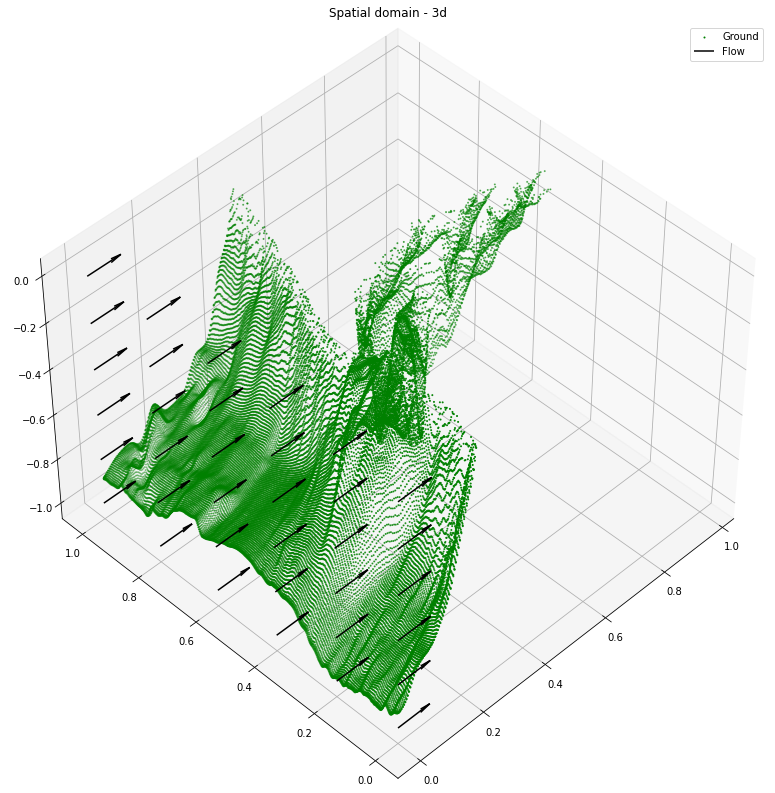

Number of points on the ground: 52689


In [8]:
filename = './Images/domain3d.png'
utils.plot_3d_domain_and_arrows(XYZ_shoal, numpy.array([1,0, 0]), filename)
print('Number of points on the ground:', XYZ_shoal.shape[0])

##### Reading 2d data

In [9]:
data_frontier = pandas.read_csv("./Data/normalized_frontier.csv").to_numpy()
XYZ_frontier = jax.numpy.column_stack((data_frontier[:,0], data_frontier[:,1], data_frontier[:,2]-1))

##### Preprocessing

In [10]:
### Inside data
XY_inside = XYZ_shoal[:,:2]


#### Boundary data
### Left
x =  jax.numpy.array([0])
y = jax.numpy.linspace(0, 1, 500+1, endpoint = False)
x, y = jax.numpy.meshgrid(x,y)
x, y = x.flatten(), y.flatten()
xy_left = jax.numpy.column_stack((x, y))


### Right
xy_right = XYZ_frontier[:,:2]


### Down
extreme_points_y =  xy_right[xy_right[:, 1].argsort()]
x = jax.numpy.linspace(extreme_points_y[0,0], 0, 200+1, endpoint = False)
y =  jax.numpy.array([0.0])
x, y = jax.numpy.meshgrid(x,y)
x, y = x.flatten(), y.flatten()
xy_down = jax.numpy.column_stack((x, y))


### Up
extreme_points_y =  xy_right[xy_right[:, 1].argsort()]
x = jax.numpy.linspace(0, extreme_points_y[-1,0], 300+1, endpoint = False)
y =  jax.numpy.array([1.0])
x, y = jax.numpy.meshgrid(x,y)
x, y = x.flatten(), y.flatten()
xy_up = jax.numpy.column_stack((x, y))

##### Get normals

In [11]:
xy_left_normals = utils.get_unitary_normals_regular2d(xy_left)
xy_up_normals = utils.get_unitary_normals_regular2d(xy_up)
xy_right_normals = utils.get_unitary_normals_pcd3d(XYZ_frontier)
xy_down_normals = utils.get_unitary_normals_regular2d(xy_down)

##### Organizing in a list and plotting normals

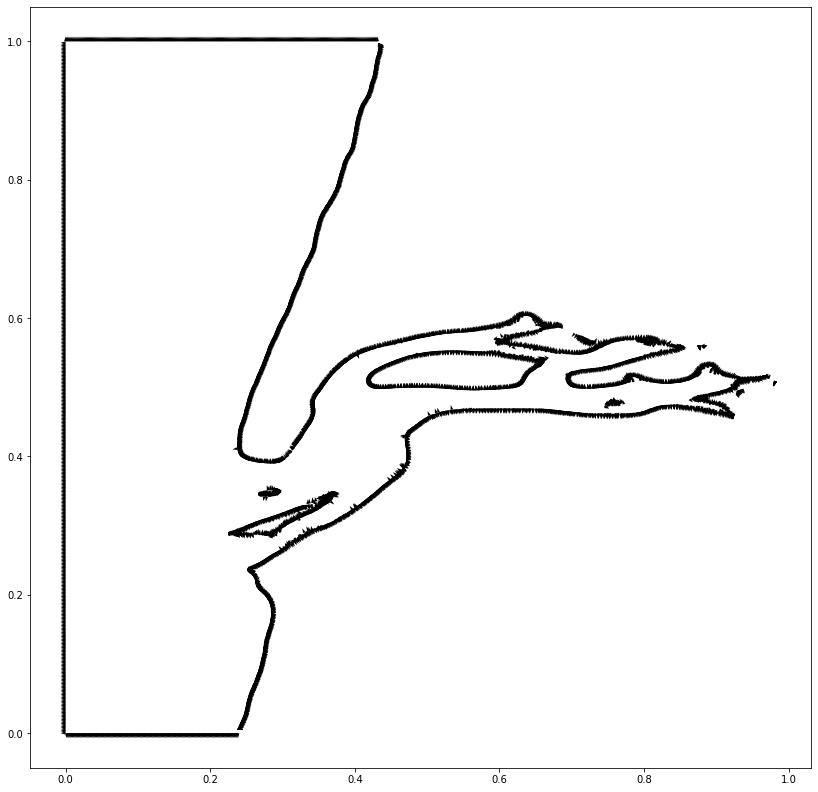

In [12]:
xy_bound_normals_list = [xy_left_normals, xy_up_normals, xy_right_normals, xy_down_normals]
xy_bound_list = [xy_left, xy_up, xy_right, xy_down]
normals = jax.numpy.concatenate((xy_left_normals, xy_up_normals, xy_right_normals, xy_down_normals))
bounds = jax.numpy.concatenate((xy_left, xy_up, xy_right, xy_down))
utils.plot_normals_2d(bounds, normals, './Images/normals.png')

##### 2D plot

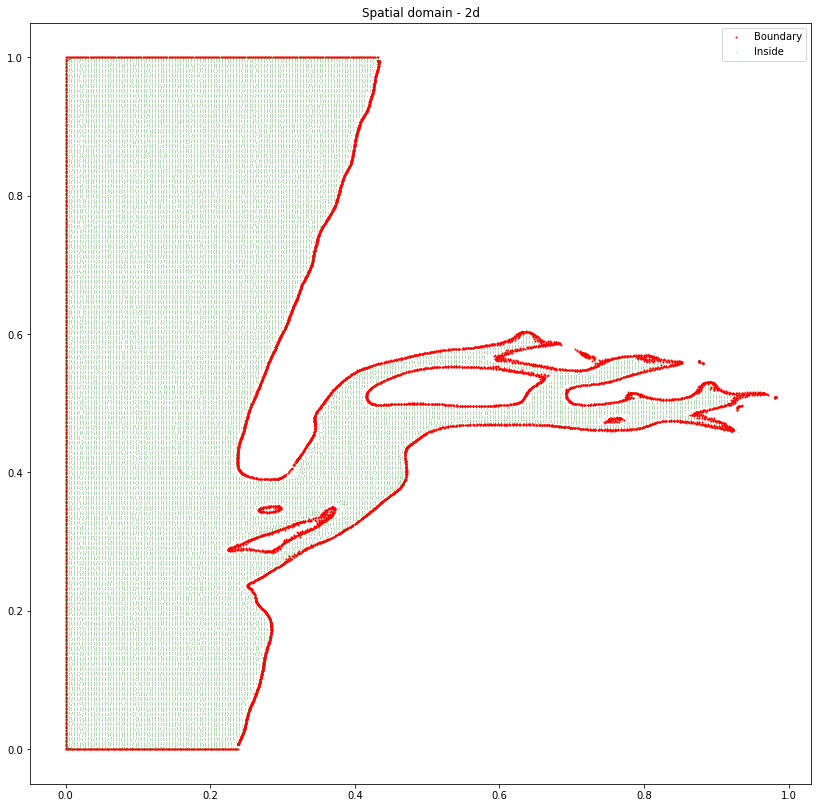

Number of points inside the domain: 52689
Number of points in the boundary: 8106


In [13]:
XY_bound = jax.numpy.concatenate((xy_left, xy_up, xy_right, xy_down))
filename = './Images/domain2d.png'
utils.plot_2d_domain(XY_inside, XY_bound, filename)

print('Number of points inside the domain:', XY_inside.shape[0])
print('Number of points in the boundary:', XY_bound.shape[0])

# Model initialization

In [14]:
key = jax.random.PRNGKey(parameters['seed'])
NN_MLP = MLP(key, parameters['layers'])                 
params = NN_MLP.MLP_create()              # Create the MLP
NN_eval = NN_MLP.NN_evaluation            # Evaluation function
solver = PINN(NN_eval, parameters['optimizer'], XYZ_shoal)
opt_state = parameters['optimizer'].init(params)

# Training

In [ ]:
loss_history = []
print("Training start")
if parameters['options'] == 1:            # begin a new training
    loss_history = []
    loss_residual = []               # residual loss
    loss_boundary = []               # boundary loss

    # Main loop to solve the PDE
    for ibatch in range(parameters['maximum_num_epochs']+1):
        loss, params, opt_state, losses = solver.train_step(params, opt_state, XY_inside, xy_bound_list, xy_bound_normals_list)

        loss_residual.append(float(losses[0]))
        loss_boundary.append(float(losses[1]))

        losssum = jax.numpy.sum(losses)
        loss_history.append(float(losssum))

        if ibatch%parameters['report_steps']==parameters['report_steps']-1:
            print("Epoch n°{}: ".format(ibatch+1), losssum.item())

        if losssum<=numpy.min(loss_history): # save if the current state is the best 
            pickle.dump(params, open("./Checkpoints/params_checkpoint_mild", "wb"))
            pickle.dump(opt_state, open("./Checkpoints/opt_state_checkpoint_mild", "wb"))
            pickle.dump(loss_history, open("./Checkpoints/loss_history_mild", "wb"))
            pickle.dump(loss_residual, open("./Checkpoints/loss_residual_mild", "wb"))
            pickle.dump(loss_boundary, open("./Checkpoints/loss_boundary_mild", "wb"))


elif parameters['options'] == 2:      # continue the last training
    params = pickle.load(open("./Checkpoints/params_checkpoint_mild", "rb"))
    opt_state = pickle.load(open("./Checkpoints/opt_state_checkpoint_mild", "rb"))
    loss_history = pickle.load(open("./Checkpoints/loss_history_mild", "rb"))
    loss_residual = pickle.load(open("./Checkpoints/loss_residual_mild", "rb"))
    loss_boundary = pickle.load(open("./Checkpoints/loss_boundary_mild", "rb"))
    iepoch = len(loss_history)
    
    # Main loop to solve the PDE
    for ibatch in range(iepoch,parameters['maximum_num_epochs']+1):
        loss, params, opt_state, losses = solver.train_step(params, opt_state, XY_inside, xy_bound_list, xy_bound_normals_list)

        loss_residual.append(float(losses[0]))
        loss_boundary.append(float(losses[1]))

        losssum = jax.numpy.sum(losses)
        loss_history.append(float(losssum))

        if ibatch%parameters['report_steps']==parameters['report_steps']-1:
            print("Epoch n°{}: ".format(ibatch+1), losssum.item())

        if losssum<=numpy.min(loss_history): # save if the current state is the best 
            pickle.dump(params, open("./Checkpoints/params_checkpoint_mild", "wb"))
            pickle.dump(opt_state, open("./Checkpoints/opt_state_checkpoint_mild", "wb"))
            pickle.dump(loss_history, open("./Checkpoints/loss_history_mild", "wb"))
            pickle.dump(loss_residual, open("./Checkpoints/loss_residual_mild", "wb"))
            pickle.dump(loss_boundary, open("./Checkpoints/loss_boundary_mild", "wb"))


else:
    params = pickle.load(open("./Checkpoints/params_checkpoint_mild", "rb"))
    opt_state = pickle.load(open("./Checkpoints/opt_state_checkpoint_mild", "rb"))
    loss_history = pickle.load(open("./Checkpoints/loss_history_mild", "rb"))
    loss_residual = pickle.load(open("./Checkpoints/loss_residual_mild", "rb"))
    loss_boundary = pickle.load(open("./Checkpoints/loss_boundary_mild", "rb"))

Training start
Epoch n°100:  0.0008185516241773018
Epoch n°200:  0.0002488315398472504
Epoch n°300:  7.021286071321978e-05
Epoch n°400:  2.3691463446396115e-05
Epoch n°500:  1.2649742092089398e-05
Epoch n°600:  9.493550157804691e-06
Epoch n°700:  8.083910962394906e-06
Epoch n°800:  7.204904943924698e-06
Epoch n°900:  6.559682074996642e-06
Epoch n°1000:  6.0451488257397184e-06
Epoch n°1100:  5.617609810036115e-06
Epoch n°1200:  5.256032799998521e-06
Epoch n°1300:  4.9483943113103615e-06
Epoch n°1400:  4.6866411876056054e-06
Epoch n°1500:  4.464388435144892e-06
Epoch n°1600:  4.276051885580099e-06
Epoch n°1700:  4.116597924590515e-06
Epoch n°1800:  3.981362503839311e-06
Epoch n°1900:  3.86612042641412e-06
Epoch n°2000:  3.7670637518353873e-06
Epoch n°2100:  3.680918834339878e-06
Epoch n°2200:  3.60493147114956e-06
Epoch n°2300:  3.536855186426265e-06
Epoch n°2400:  3.4748990543731923e-06
Epoch n°2500:  3.4177008665428967e-06


# Loss function plot

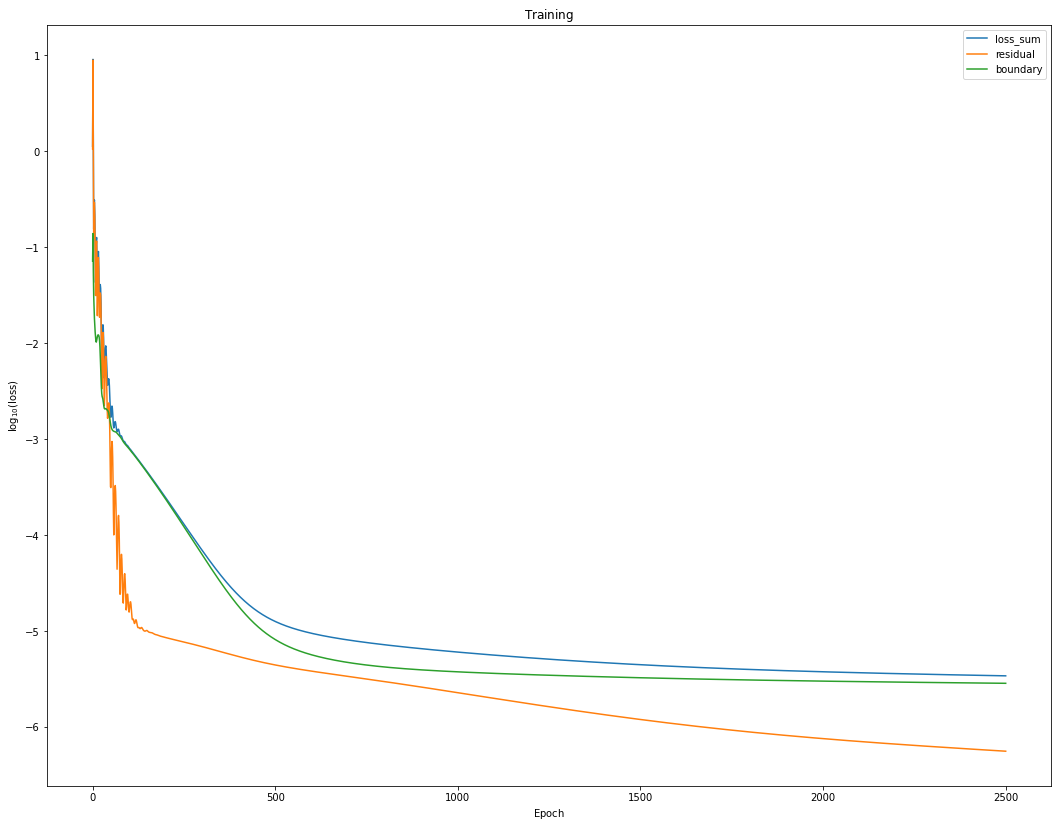

In [ ]:
path = './Images/loss_function.png'
losses = [loss_history, loss_residual, loss_boundary]
utils.plot_loss_history(losses, path)

# Load best params of the training

In [15]:
params = pickle.load(open("./Checkpoints/params_checkpoint_mild", "rb"))

# Elevation 2D animation

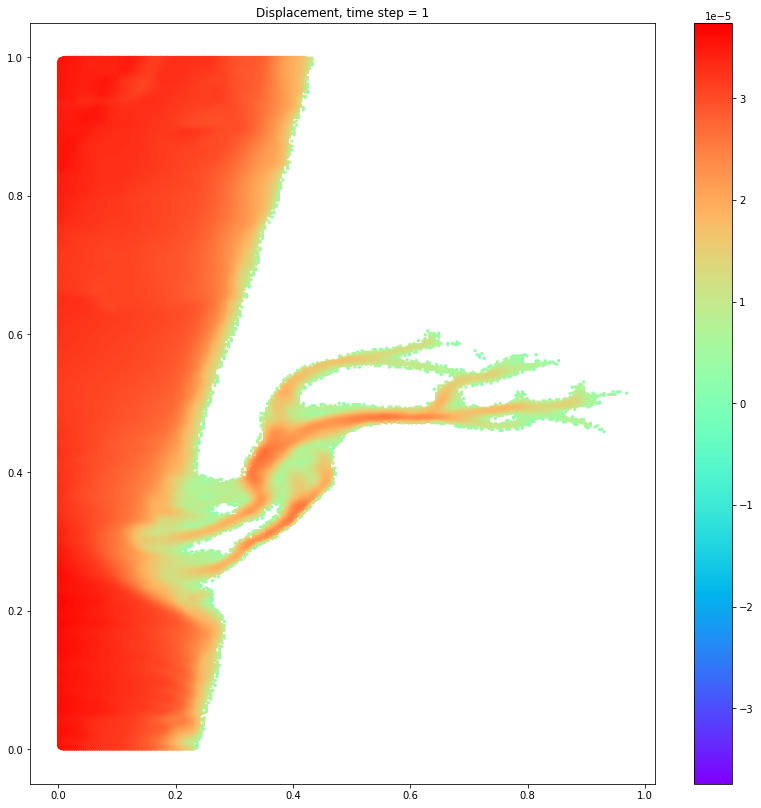

In [ ]:
frames = 200
end_time = 250.0
path = './Images/mild_slope_animation2d.gif'

utils.plot_2d_animation(XYZ_shoal[:,:2], params, solver.elevation, end_time, frames, path, scale = 1)

# Elevation 3D animation

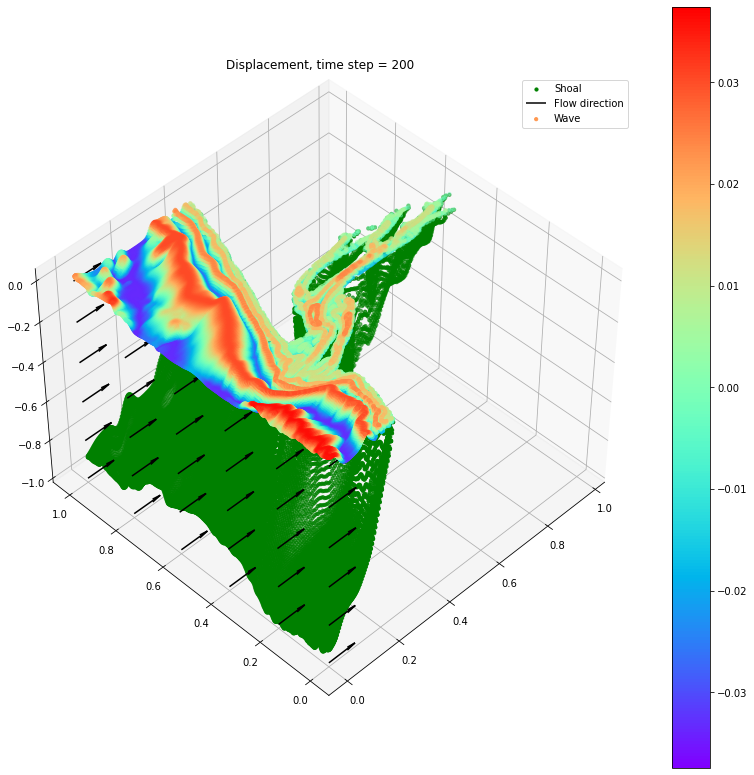

In [16]:
npoints = XYZ_shoal.shape[0]
frames = 200
end_time = 250.0
path = './Images/mild_slope_animation3d_scale1000.gif'
flow_direction = jax.numpy.array([1, 0, 0])

utils.plot_3d_animation_and_arrows(XYZ_shoal, params, solver.elevation, flow_direction, end_time, frames, path, scale = 1000)